# Prototype hybrid matrix factorization model for drug reccomendations using PyTorch

## Setup

In [1]:
# Standard imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import dill

from scipy.stats import pearsonr

import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader


from sklearn import metrics

In [2]:
# Custom utilities imports
sys.path.append("/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Modules")
from modeling import Dataset, evaluate_predictions

## Load KINOMEscan preprocessed dataset with intersection of proteins screened for drugs

In [3]:
filepath = "../../Data/Preprocessed Datasets/"
with open(filepath + "GDSC-KINOMEscan_proteins_intersection_dataset.pkl", "rb") as f:
    full_dataset = dill.load(f)
print(full_dataset.name, type(full_dataset))
print()
print(full_dataset.description)

Kinases Dataset <class 'modeling.Dataset'>

Dataset containing 74 common drugs of GDSC and HMS LINCS Kinome scan dataset. 
- Cell lines data types: expression, coding variant and tissue type. Expressions and coding variants are 
present only for proteins present in both GDSC and KINOMEscan data, resulting in expression of 188 genes and
mutations in 18 genes. Tissue types are dummy encoded GDSC Tissue Descriptions 1 (18 features).
- Drugs representation: inhibition scores (% control) of 294 proteins. Set of proteins is the intersection of 
proteins screened for each of 74 drugs.
- Drug response data: drug reponse data contains AUC metrics across cell lines for 74 drugs considered 


## Data preprocessing

#### Establish response data for samples (drug-cell line pairs)

In [4]:
response_df = full_dataset.response_data.copy()
print(response_df.shape, response_df.COSMIC_ID.nunique())
response_df.head(3)

(55936, 3) 987


,DRUG_ID,COSMIC_ID,AUC
2748,29,683665,0.945160
2749,29,684055,0.926046
2750,29,684057,0.934873


#### Establish cell line features data

In [5]:
cell_line_data_df = full_dataset.full_cell_lines_data.copy()
print(cell_line_data_df.shape)
cell_line_data_df.head(3)

(922, 225)


,cell_line_id,PRKX_exp,TIE1_exp,BMPR2_exp,PKMYT1_exp,ABL2_exp,PLK1_exp,ACVR1_exp,MAP3K4_mut,SRPK1_exp,...,Tissue_lung_SCLC,Tissue_lymphoma,Tissue_myeloma,Tissue_nervous_system,Tissue_neuroblastoma,Tissue_pancreas,Tissue_skin,Tissue_soft_tissue,Tissue_thyroid,Tissue_urogenital_system
cell_line_id,,,,,,,,,,,,,,,,,,,,,
906826,906826,4.787607,3.056350,6.395463,5.550737,5.492917,3.853142,4.384087,0,7.410108,...,0,0,0,0,0,0,0,0,0,0
687983,687983,5.001763,3.125097,6.634672,5.399054,5.113815,4.218736,4.786061,0,7.776150,...,1,0,0,0,0,0,0,0,0,0
910927,910927,5.459631,2.989998,7.945827,5.541005,4.519127,3.694307,4.414635,0,7.079021,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Search for cell lines present in response data, but missing the genomic features
missing_cell_lines = []
for cosmic_id in response_df.COSMIC_ID.unique():
    if cosmic_id not in cell_line_data_df.cell_line_id.unique():
        missing_cell_lines.append(cosmic_id)
print(len(missing_cell_lines))

66


In [7]:
# Put cell line IDs into index and drop cell line IDs columns
cell_line_data_df.index = cell_line_data_df.cell_line_id
cell_line_data_df = cell_line_data_df.drop("cell_line_id", axis=1)

In [8]:
# Extract response only for cell lines for which features are present
print(response_df.shape)
response_df = response_df[~response_df.COSMIC_ID.isin(missing_cell_lines)]
print(response_df.shape)

(55936, 3)
(52730, 3)


#### Establish drug features data

In [9]:
drug_data_df = full_dataset.drugs_data.copy()
print(drug_data_df.shape)
# Convert drug index from LINCS name to GDSC drug ID
drug_data_df.index = drug_data_df.index.map(full_dataset.kinomescan_name_to_gdsc_id_mapper)
drug_data_df.head(3)

(74, 294)


Protein,MAPKAPK2,MARK1,CAMKK2,MARK2,TGFBR1,ERK5,EPHA7,MK01,RAF1,TNNI3K,...,KGP1,ZAP70,ERK3,BLK,MYLK2,KPCD3,FGFR3,ACVR1,GSK3A,KPCD
Small Molecule,,,,,,,,,,,,,,,,,,,,,
1242,100.0,83.0,88.0,96.0,57.0,100.0,92.0,64.0,100.0,77.0,...,99.0,86.0,98.0,57.0,80.0,12.0,95.0,1.9,100.0,100.0
86,100.0,100.0,2.0,13.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.7,100.0,100.0,100.0,100.0,1.6,100.0,100.0,1.0,0.9
29,100.0,100.0,28.0,92.0,100.0,100.0,84.0,100.0,2.3,15.0,...,100.0,100.0,100.0,1.0,100.0,88.0,100.0,100.0,100.0,89.0


In [10]:
# Search for drugs present in response data, but missing the drug features
missing_drugs = []
for drug_id in response_df.DRUG_ID.unique():
    if drug_id not in drug_data_df.index:
        print(drug_id)
        missing_drugs.append(drug_id)
print(len(missing_drugs))

0


#### Split drug response data into training/validation/test 

In [11]:
print(cell_line_data_df.shape, drug_data_df.index.nunique(), cell_line_data_df.index.nunique())
print(response_df.shape, response_df.DRUG_ID.nunique(), response_df.COSMIC_ID.nunique())

(922, 224) 74 922
(52730, 3) 74 921


In [12]:
# Split the data into train, validation and test, separating subset of cell lines
# val_ratio = 0.25
# num_separated_cell_lines = 30

# # Extract samples with cell lines separated from training
# separated_cell_lines = list(np.random.choice(response_df.COSMIC_ID.unique(), size=20))
# separated_samples = response_df[response_df.COSMIC_ID.isin(separated_cell_lines)]

# # Extract rest
# rest = response_df[~response_df.COSMIC_ID.isin(separated_cell_lines)]

# train_samples = rest[int(val_ratio * response_df.shape[0]):]
# val_samples = rest[:int(val_ratio * response_df.shape[0])]

# print(train_samples.shape, val_samples.shape, separated_samples.shape)

In [13]:
# Shuffle all the samples
response_df = response_df.sample(frac=1., random_state=2)

In [14]:
# Split the data into train, validation and test set, separating distinct cell lines
# Specify how many cell lines go to validation and test sets
num_cell_lines_val = 100
num_cell_lines_test = 100

# Extract test cell lines samples
cell_lines_test = list(np.random.choice(response_df.COSMIC_ID.unique(), size=num_cell_lines_test,
                                       replace=False))
samples_test = response_df[response_df.COSMIC_ID.isin(cell_lines_test)]

# Extract rest
rest = response_df[~response_df.COSMIC_ID.isin(cell_lines_test)]

# Extract validation cell lines samples
cell_lines_val = list(np.random.choice(rest.COSMIC_ID.unique(), size=num_cell_lines_val,
                                       replace=False))
samples_val = rest[rest.COSMIC_ID.isin(cell_lines_val)]

# Extract rest (training set)
samples_train = rest[~rest.COSMIC_ID.isin(cell_lines_val)]

print(response_df.shape, samples_train.shape, samples_val.shape, samples_test.shape)
print(response_df.COSMIC_ID.nunique(), samples_train.COSMIC_ID.nunique(), samples_val.COSMIC_ID.nunique(),
     samples_test.COSMIC_ID.nunique())

(52730, 3) (41321, 3) (5637, 3) (5772, 3)
921 721 100 100


In [15]:
set(samples_test.COSMIC_ID.unique()).intersection(set(samples_val.COSMIC_ID.unique()))

set()

#### Normalize / standardize the data

In [16]:
# Cell line data
cols_subset = [col for col in list(cell_line_data_df) if col.endswith("_exp")]
rows_subset = [x for x in cell_line_data_df.index if x not in cell_lines_test + cell_lines_val]

cell_line_data_df = Dataset.standardize_data(cell_line_data_df, cols_subset=cols_subset,
                                            rows_subset=rows_subset)
print(cell_line_data_df.shape, cell_line_data_df.mean().mean(),
     cell_line_data_df.std().sum())

(922, 224) 0.005707711310287684 194.58318467605653


In [17]:
# Drug data
print(drug_data_df.shape)
drug_data_df = Dataset.standardize_data(drug_data_df)
print(drug_data_df.shape, drug_data_df.mean().mean(),
     drug_data_df.std().sum())

(74, 294)
(74, 294) 2.196104424744604e-17 294.0


## Model definition

In [18]:
# Model definition
class LinearMatrixFactorizationWithFeatures(torch.nn.Module):
    def __init__(self, drug_input_dim, cell_line_input_dim, output_dim, 
                 out_activation_func=None,
                 drug_bias=True,
                 cell_line_bias=True):
        super(LinearMatrixFactorizationWithFeatures, self).__init__()
        self.drug_linear = torch.nn.Linear(drug_input_dim, output_dim, bias=drug_bias)
        self.cell_line_linear = torch.nn.Linear(cell_line_input_dim, output_dim, bias=cell_line_bias)
        self.out_activation = out_activation_func
        
    def forward(self, drug_features, cell_line_features):
        drug_outputs = self.drug_linear(drug_features)
        cell_line_outputs = self.cell_line_linear(cell_line_features)
        
        final_outputs = torch.sum(torch.mul(drug_outputs, cell_line_outputs), dim=1).view(-1, 1)
        if self.out_activation:
            return self.out_activation(final_outputs)
        return final_outputs

## Model training

In [19]:
# Take sample of whole training data if needed
samples_train = samples_train.sample(1000, random_state=2)
print(samples_train.shape, samples_train["AUC"].mean())

(1000, 3) 0.839491998


#### Specify hyperparameters

In [21]:
# Specify shape of input
drug_dim = drug_data_df.shape[1]
cell_line_dim = cell_line_data_df.shape[1]

# Specify learning hyperparameters
learning_rate = 0.04
epochs = 100
output_dim = 10
batch_size = 32
no_batches = samples_train.shape[0] // batch_size + 1

model = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, output_dim,
                                             drug_bias=True,
                                             cell_line_bias=True,
                                             out_activation_func=torch.sigmoid)

# Define loss function and optimizer
weight_decay = 0.
reg_lambda = 0.

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Display text representation of model
model

LinearMatrixFactorizationWithFeatures(
  (drug_linear): Linear(in_features=294, out_features=10, bias=True)
  (cell_line_linear): Linear(in_features=224, out_features=10, bias=True)
)

#### Training loop

In [22]:
# Training the model
model.train()
for epoch in range(epochs):
    for batch in range(no_batches):
        # Separate response variable batch
        if batch != no_batches:
            samples_batch = samples_train.iloc[batch * batch_size:(batch + 1) * batch_size]
        else:
            samples_batch = samples_train.iloc[batch * batch_size:]
            
        # Extract output variable batch
        y_batch = torch.from_numpy(samples_batch["AUC"].values).view(-1, 1)
        
        # Extract cell lines IDs for which data shall be extracted
        cl_ids = samples_batch["COSMIC_ID"].values
        # Extract corresponding cell line data
        cell_line_input_batch = cell_line_data_df.loc[cl_ids].values
        cell_line_input_batch = torch.from_numpy(cell_line_input_batch)
        
        # Extract drug IDs for which data shall be extracted
        drug_ids = samples_batch["DRUG_ID"].values
        # Extract corresponding drug data
        drug_input_batch = drug_data_df.loc[drug_ids].values
        drug_input_batch = torch.from_numpy(drug_input_batch)
        
        # Clear gradient buffers because we don't want to accummulate gradients 
        optimizer.zero_grad()
        
        # Perform forward pass
        batch_output = model(drug_input_batch.float(), cell_line_input_batch.float())
        
        reg = 0
        for param in model.parameters():
            reg += 0.5 * (param ** 2).sum()  # L2 norm
        
        # Compute the loss for this batch
        loss = criterion(batch_output, y_batch.float()) + reg_lambda * reg
        # Get the gradients w.r.t. the parameters
        loss.backward()
        # Update the parameters
        optimizer.step()
        
        #print("Epoch {}, batch {}, loss: {:.3f}".format(epoch + 1, batch + 1, loss.item()))
    print("Epoch {}, loss: {:.4f}".format(epoch + 1, loss.item()))

Epoch 1, loss: 0.1414
Epoch 2, loss: 0.0697
Epoch 3, loss: 0.0445
Epoch 4, loss: 0.0276
Epoch 5, loss: 0.0164
Epoch 6, loss: 0.0104
Epoch 7, loss: 0.0075
Epoch 8, loss: 0.0057
Epoch 9, loss: 0.0043
Epoch 10, loss: 0.0034
Epoch 11, loss: 0.0028
Epoch 12, loss: 0.0024
Epoch 13, loss: 0.0021
Epoch 14, loss: 0.0018
Epoch 15, loss: 0.0016
Epoch 16, loss: 0.0015
Epoch 17, loss: 0.0013
Epoch 18, loss: 0.0012
Epoch 19, loss: 0.0011
Epoch 20, loss: 0.0011
Epoch 21, loss: 0.0010
Epoch 22, loss: 0.0009
Epoch 23, loss: 0.0009
Epoch 24, loss: 0.0008
Epoch 25, loss: 0.0008
Epoch 26, loss: 0.0007
Epoch 27, loss: 0.0007
Epoch 28, loss: 0.0007
Epoch 29, loss: 0.0006
Epoch 30, loss: 0.0006
Epoch 31, loss: 0.0006
Epoch 32, loss: 0.0006
Epoch 33, loss: 0.0006
Epoch 34, loss: 0.0005
Epoch 35, loss: 0.0005
Epoch 36, loss: 0.0005
Epoch 37, loss: 0.0005
Epoch 38, loss: 0.0005
Epoch 39, loss: 0.0005
Epoch 40, loss: 0.0005
Epoch 41, loss: 0.0005
Epoch 42, loss: 0.0005
Epoch 43, loss: 0.0004
Epoch 44, loss: 0.00

## Model evaluation

In [23]:
# Establish mean of AUC in training data for baseline model evaluation
mean_training_auc = samples_train["AUC"].mean()

#### Evaluate on training data

In [24]:
# Do some sample predictions on trainig data
# Sample data points
sample = samples_train.sample(3)
sample

,DRUG_ID,COSMIC_ID,AUC
51375,1564,909770,0.763129
28656,157,1331032,0.627742
56049,203,753582,0.765652


In [25]:
# Do some predictions on training data
cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
print(predicted, predicted.shape)

tensor([[0.7744],
        [0.6180],
        [0.7385]]) torch.Size([3, 1])


In [26]:
# Do predictions manually
drug_out = torch.from_numpy(drug_input[0].reshape(-1, 294)).float() @ model.drug_linear.weight.t() + \
                                                                    model.drug_linear.bias
cl_out = torch.from_numpy(cl_input[0].reshape(-1, 224)).float() @ model.cell_line_linear.weight.t() + \
                                                            model.cell_line_linear.bias
final_out = torch.zeros(drug_out.shape[0])
for k in range(drug_out.shape[1]):
    final_out = final_out + drug_out[:, k] * cl_out[:, k]
print(final_out.shape, final_out)

torch.Size([1]) tensor([1.2332], grad_fn=<AddBackward0>)


In [27]:
# Predict on training data
sample = samples_train.iloc[:]
y_true = sample["AUC"].values

# Create baseline predictions(mean AUC)
mean_preds = np.array([mean_training_auc] * sample.shape[0])

cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print(predicted.shape, predicted.max(), predicted.min(), predicted.mean())
print("Baseline scores:")
evaluate_predictions(y_true, mean_preds)
print()
print("Model scores:")
print(predicted.max(), predicted.min(), predicted.mean())
evaluate_predictions(y_true, predicted.reshape(-1))

torch.Size([1000, 1]) tensor(0.9998) tensor(0.0032) tensor(0.8278)
Baseline scores:
RMSE: 0.1809899693056732
Correlation: (nan, nan)

Model scores:
tensor(0.9998) tensor(0.0032) tensor(0.8278)
RMSE: 0.03989179944196873
Correlation: (0.9755886142030082, 0.0)


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [28]:
# Compute evaluation metrics per drug
sample_with_predictions = sample.copy()
sample_with_predictions["Predicted AUC"] = predicted.numpy()

drugs = []
model_corrs = []
model_rmses = []
dummy_corrs = []
dummy_rmses = []
no_samples = []

for drug in sample_with_predictions.DRUG_ID.unique():
    df = sample_with_predictions[sample_with_predictions.DRUG_ID == drug]
    dummy_preds = [mean_training_auc] * df.shape[0]
    dummy_rmse = metrics.mean_squared_error(df["AUC"], dummy_preds) ** 0.5
    dummy_corr = pearsonr(df["AUC"], dummy_preds)
    
    model_rmse = metrics.mean_squared_error(df["AUC"], df["Predicted AUC"]) ** 0.5
    model_corr = pearsonr(df["AUC"], df["Predicted AUC"])
    
    drugs.append(drug)
    dummy_rmses.append(dummy_rmse)
    dummy_corrs.append(dummy_corr[0])
    
    model_rmses.append(model_rmse)
    model_corrs.append(model_corr[0])
    
    no_samples.append(df.COSMIC_ID.nunique())

corrs_per_drug = pd.DataFrame()
corrs_per_drug["Drug ID"] = drugs
corrs_per_drug["Model RMSE"] = model_rmses
corrs_per_drug["Model correlation"] = model_corrs

corrs_per_drug["Dummy RMSE"] = dummy_rmses
corrs_per_drug["Dummy correlation"] = dummy_corrs
corrs_per_drug["No. samples"] = no_samples

print(corrs_per_drug.shape, corrs_per_drug["Drug ID"].nunique())
print(corrs_per_drug["Model correlation"].median())

(73, 6) 73
0.9562221880874111


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [29]:
corrs_per_drug.sort_values("Model correlation", ascending=False).head()

,Drug ID,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
53,374,0.009294,0.999395,0.242848,NaN,14
6,159,0.012356,0.998503,0.156630,NaN,13
10,371,0.015868,0.998382,0.263676,NaN,21
16,1161,0.008251,0.998074,0.128990,NaN,9
2,56,0.011818,0.997088,0.139967,NaN,12


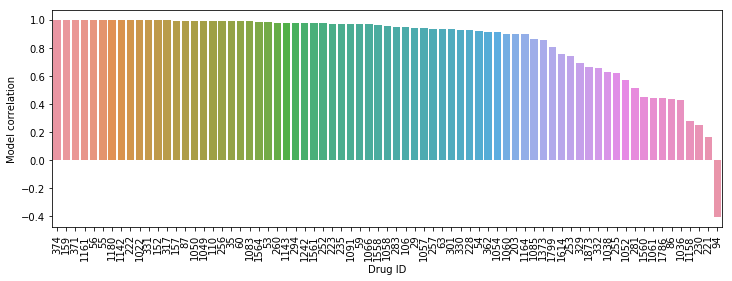

In [30]:
# Plot per-drug results
plt.figure(figsize=(12, 4))
plt.xticks(rotation=90)
sns.barplot(x="Drug ID", y="Model correlation", data=corrs_per_drug,
           order=corrs_per_drug.sort_values("Model correlation", ascending=False)["Drug ID"])

plt.show()

#### Evaluation on validation set

In [63]:
print(samples_val.shape)

(5866, 3)


In [64]:
# Predict on validation data and evaluate
sample = samples_val[:]
y_true = sample["AUC"].values

# Create baseline predictions(mean AUC)
mean_preds = np.array([mean_training_auc] * sample.shape[0])

cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print(predicted.shape, predicted.max(), predicted.min(), predicted.mean())
print("Baseline scores:")
evaluate_predictions(y_true, mean_preds)
print()

print("Model scores:")
print(predicted.max(), predicted.min(), predicted.mean())
evaluate_predictions(y_true, predicted.view(-1))

torch.Size([5866, 1]) tensor(2.3811) tensor(-4.0338) tensor(0.5972)
Baseline scores:
RMSE: 0.18352162371871672
Correlation: (nan, nan)

Model scores:
tensor(2.3811) tensor(-4.0338) tensor(0.5972)
RMSE: 0.5463192625697165
Correlation: (0.11624790267467003, 4.1911948227930274e-19)


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [65]:
# Compute evaluation metrics per drug
sample_with_predictions = sample.copy()
sample_with_predictions["Predicted AUC"] = predicted.numpy()

drugs = []
model_corrs = []
model_rmses = []
dummy_corrs = []
dummy_rmses = []
no_samples = []

for drug in sample_with_predictions.DRUG_ID.unique():
    df = sample_with_predictions[sample_with_predictions.DRUG_ID == drug]
    dummy_preds = [mean_training_auc] * df.shape[0]
    dummy_rmse = metrics.mean_squared_error(df["AUC"], dummy_preds) ** 0.5
    dummy_corr = pearsonr(df["AUC"], dummy_preds)
    
    model_rmse = metrics.mean_squared_error(df["AUC"], df["Predicted AUC"]) ** 0.5
    model_corr = pearsonr(df["AUC"], df["Predicted AUC"])
    
    drugs.append(drug)
    dummy_rmses.append(dummy_rmse)
    dummy_corrs.append(dummy_corr[0])
    
    model_rmses.append(model_rmse)
    model_corrs.append(model_corr[0])
    
    no_samples.append(df.COSMIC_ID.nunique())

corrs_per_drug = pd.DataFrame()
corrs_per_drug["Drug ID"] = drugs
corrs_per_drug["Model RMSE"] = model_rmses
corrs_per_drug["Model correlation"] = model_corrs

corrs_per_drug["Dummy RMSE"] = dummy_rmses
corrs_per_drug["Dummy correlation"] = dummy_corrs
corrs_per_drug["No. samples"] = no_samples

print(corrs_per_drug.shape, corrs_per_drug["Drug ID"].nunique())
print(corrs_per_drug["Model correlation"].median())

(74, 6) 74
0.032948457949925736


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


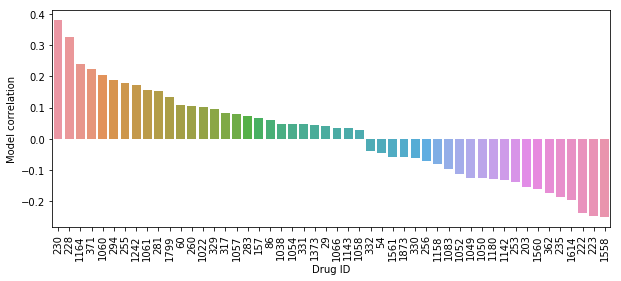

In [66]:
# Plot per-drug results
plt.figure(figsize=(12, 4))
plt.xticks(rotation=90)
sns.barplot(x="Drug ID", y="Model correlation", data=corrs_per_drug,
           order=corrs_per_drug.sort_values("Model correlation", ascending=False)["Drug ID"])

plt.show()

#### Evaluate on unseen cell lines

In [67]:
# Predict on unseen cell lines and evaluate
sample = samples_test
y_true = sample["AUC"].values

cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print(predicted.max(), predicted.min(), predicted.mean())
evaluate_predictions(y_true, predicted.view(-1))

tensor(2.1030) tensor(-3.6626) tensor(0.5473)
RMSE: 0.5226993060739263
Correlation: (0.1527588729585517, 5.247973552308591e-31)


In [68]:
# Compute evaluation metrics per drug
sample_with_predictions = sample.copy()
sample_with_predictions["Predicted AUC"] = predicted.numpy()

drugs = []
model_corrs = []
model_rmses = []
dummy_corrs = []
dummy_rmses = []
no_samples = []

for drug in sample_with_predictions.DRUG_ID.unique():
    df = sample_with_predictions[sample_with_predictions.DRUG_ID == drug]
    dummy_preds = [mean_training_auc] * df.shape[0]
    dummy_rmse = metrics.mean_squared_error(df["AUC"], dummy_preds) ** 0.5
    dummy_corr = pearsonr(df["AUC"], dummy_preds)
    
    model_rmse = metrics.mean_squared_error(df["AUC"], df["Predicted AUC"]) ** 0.5
    model_corr = pearsonr(df["AUC"], df["Predicted AUC"])
    
    drugs.append(drug)
    dummy_rmses.append(dummy_rmse)
    dummy_corrs.append(dummy_corr[0])
    
    model_rmses.append(model_rmse)
    model_corrs.append(model_corr[0])
    
    no_samples.append(df.COSMIC_ID.nunique())

corrs_per_drug = pd.DataFrame()
corrs_per_drug["Drug ID"] = drugs
corrs_per_drug["Model RMSE"] = model_rmses
corrs_per_drug["Model correlation"] = model_corrs

corrs_per_drug["Dummy RMSE"] = dummy_rmses
corrs_per_drug["Dummy correlation"] = dummy_corrs
corrs_per_drug["No. samples"] = no_samples

print(corrs_per_drug.shape, corrs_per_drug["Drug ID"].nunique())
print(corrs_per_drug["Model correlation"].median())

(74, 6) 74
0.05985532956288445


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


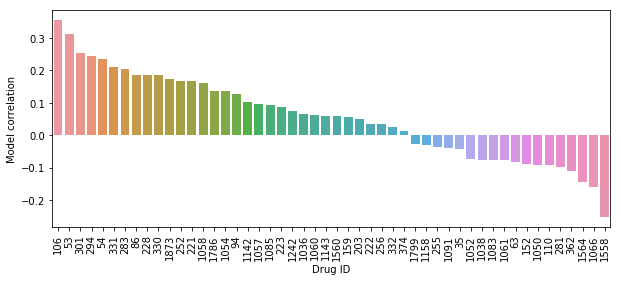

In [69]:
# Plot per-drug results
plt.figure(figsize=(12, 4))
plt.xticks(rotation=90)
sns.barplot(x="Drug ID", y="Model correlation", data=corrs_per_drug,
           order=corrs_per_drug.sort_values("Model correlation", ascending=False)["Drug ID"])

plt.show()

## Prototype Model class

In [61]:
class Model:
    def __init__(self, name, network):
        self.name = name
        self.network = network
        
    def train(self, train_samples, cell_line_features, drug_features,
             batch_size, optimizer, criterion, reg_lambda=0, log=True):
        """Perform training process by looping over training set in batches (one epoch) of the
        training."""
        no_batches = train_samples.shape[0] // batch_size + 1
        
        # Training the model
        self.network.train()
        for batch in range(no_batches):
            # Separate response variable batch
            if batch != no_batches:
                samples_batch = train_samples.iloc[batch * batch_size:(batch + 1) * batch_size]
            else:
                samples_batch = train_samples.iloc[batch * batch_size:]

            # Extract output variable batch
            y_batch = torch.from_numpy(samples_batch["AUC"].values).view(-1, 1)

            # Extract cell lines IDs for which data shall be extracted
            cl_ids = samples_batch["COSMIC_ID"].values
            # Extract corresponding cell line data
            cell_line_input_batch = cell_line_features.loc[cl_ids].values
            cell_line_input_batch = torch.from_numpy(cell_line_input_batch)

            # Extract drug IDs for which data shall be extracted
            drug_ids = samples_batch["DRUG_ID"].values
            # Extract corresponding drug data
            drug_input_batch = drug_features.loc[drug_ids].values
            drug_input_batch = torch.from_numpy(drug_input_batch)

            # Clear gradient buffers because we don't want to accummulate gradients 
            optimizer.zero_grad()

            # Perform forward pass
            batch_output = self.network(drug_input_batch.float(), cell_line_input_batch.float())

            reg_sum = 0
            for param in self.network.parameters():
                reg_sum += 0.5 * (param ** 2).sum()  # L2 norm

            # Compute the loss for this batch
            loss = criterion(batch_output, y_batch.float()) + reg_lambda * reg_sum
            # Get the gradients w.r.t. the parameters
            loss.backward()
            # Update the parameters
            optimizer.step()
        return loss
    
    def predict(self, samples, cell_line_features, drug_features):
        """Predict response on a given set of samples"""
        y_true = sample["AUC"].values

        cl_input = cell_line_features.loc[samples["COSMIC_ID"].values].values
        drug_input = drug_features.loc[samples["DRUG_ID"].values].values

        self.network.eval()
        with torch.no_grad():
            predicted = model_test.network(torch.from_numpy(drug_input).float(), 
                             torch.from_numpy(cl_input).float())
        return predicted, y_true
    
    @staticmethod
    def predicted_vs_actual_df(samples, predicted):
        """Compute evaluation metrics per drug and return them in a DataFrame"""
        sample_with_predictions = samples.copy()
        sample_with_predictions["Predicted AUC"] = predicted.numpy()

        drugs = []
        model_corrs = []
        model_rmses = []
        dummy_corrs = []
        dummy_rmses = []
        no_samples = []

        for drug in sample_with_predictions.DRUG_ID.unique():
            df = sample_with_predictions[sample_with_predictions.DRUG_ID == drug]
            dummy_preds = [mean_training_auc] * df.shape[0]
            dummy_rmse = metrics.mean_squared_error(df["AUC"], dummy_preds) ** 0.5
            dummy_corr = pearsonr(df["AUC"], dummy_preds)

            model_rmse = metrics.mean_squared_error(df["AUC"], df["Predicted AUC"]) ** 0.5
            model_corr = pearsonr(df["AUC"], df["Predicted AUC"])

            drugs.append(drug)
            dummy_rmses.append(dummy_rmse)
            dummy_corrs.append(dummy_corr[0])

            model_rmses.append(model_rmse)
            model_corrs.append(model_corr[0])

            no_samples.append(df.COSMIC_ID.nunique())

        performance_per_drug = pd.DataFrame()
        performance_per_drug["Drug ID"] = drugs
        performance_per_drug["Model RMSE"] = model_rmses
        performance_per_drug["Model correlation"] = model_corrs

        performance_per_drug["Dummy RMSE"] = dummy_rmses
        performance_per_drug["Dummy correlation"] = dummy_corrs
        performance_per_drug["No. samples"] = no_samples

        return corrs_per_drug
        
    @staticmethod
    def evaluate_predictions(y_true, preds):
        """Compute RMSE and correlation with true values for model predictions"""
        return metrics.mean_squared_error(y_true, preds) ** 0.5, pearsonr(y_true, preds)

In [62]:
# Specify network shapes
drug_dim = drug_data_df.shape[1]
cell_line_dim = cell_line_data_df.shape[1]
output_dim = 10

# Specify network
network = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, output_dim,
                                             drug_bias=True,
                                             cell_line_bias=True,
                                             out_activation_func=torch.sigmoid)
# Create Model instance
model_test = Model("Test model instance", network)

# Display text representation of model
model_test.network

LinearMatrixFactorizationWithFeatures(
  (drug_linear): Linear(in_features=294, out_features=10, bias=True)
  (cell_line_linear): Linear(in_features=224, out_features=10, bias=True)
)

In [63]:
# Do the training
# Specify learning parameters
batch_size = 32
learning_rate = 0.04
weight_decay = 0.
reg_lambda = 0.

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model_test.network.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loops
epochs = 30

for epoch in range(epochs):
    loss = model_test.train(samples_train, cell_line_data_df, drug_data_df, batch_size,
                    optimizer, criterion, reg_lambda=reg_lambda)
    
    print("Epoch {}, loss: {:.4f}".format(epoch + 1, loss.item()))

Epoch 1, loss: 0.1655
Epoch 2, loss: 0.0839
Epoch 3, loss: 0.0601
Epoch 4, loss: 0.0464
Epoch 5, loss: 0.0358
Epoch 6, loss: 0.0272
Epoch 7, loss: 0.0204
Epoch 8, loss: 0.0153
Epoch 9, loss: 0.0117
Epoch 10, loss: 0.0092
Epoch 11, loss: 0.0074
Epoch 12, loss: 0.0061
Epoch 13, loss: 0.0051
Epoch 14, loss: 0.0044
Epoch 15, loss: 0.0038
Epoch 16, loss: 0.0035
Epoch 17, loss: 0.0032
Epoch 18, loss: 0.0031
Epoch 19, loss: 0.0029
Epoch 20, loss: 0.0027
Epoch 21, loss: 0.0025
Epoch 22, loss: 0.0024
Epoch 23, loss: 0.0023
Epoch 24, loss: 0.0022
Epoch 25, loss: 0.0021
Epoch 26, loss: 0.0020
Epoch 27, loss: 0.0019
Epoch 28, loss: 0.0018
Epoch 29, loss: 0.0017
Epoch 30, loss: 0.0016


In [25]:
mean_training_auc = samples_train["AUC"].mean()

In [119]:
predicted, y_true = model_test.predict(sample, cell_line_data_df, drug_data_df)
evaluate_predictions(y_true, predicted.reshape(-1))

RMSE: 0.0514340603164783
Correlation: (0.9606547328767453, 0.0)


In [120]:
df = model_test.predicted_vs_actual_df(sample, predicted)
print(df.shape, df["Drug ID"].nunique())
print(df["Model correlation"].median())

(73, 6) 73
0.9251053807930224


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


## Prototype hyperparameter tuning with Tune library

In [64]:
import ray
from ray import tune
from ray.tune import track

In [83]:
# Specify network shapes
drug_dim = drug_data_df.shape[1]
cell_line_dim = cell_line_data_df.shape[1]
output_dim = 10

# Specify network
network = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, output_dim,
                                             drug_bias=True,
                                             cell_line_bias=True,
                                             out_activation_func=torch.sigmoid)
# Create Model instance
model_test = Model("Test model instance", network)

# Display text representation of model
model_test.network

LinearMatrixFactorizationWithFeatures(
  (drug_linear): Linear(in_features=294, out_features=10, bias=True)
  (cell_line_linear): Linear(in_features=224, out_features=10, bias=True)
)

In [84]:
# Do the training
# Specify learning parameters

criterion = torch.nn.MSELoss()
# for epoch in range(epochs):
#     loss = model_test.train(samples_train, cell_line_data_df, drug_data_df, batch_size,
#                     optimizer, criterion, reg_lambda=reg_lambda)


In [85]:
model_test.network.drug_linear.weight.sum()

tensor(-2.6713, grad_fn=<SumBackward0>)

In [94]:
def trainable_for_tuning(config):
    optimizer = torch.optim.SGD(model_test.network.parameters(), lr=config["lr"])
    
    for epoch in range(1, epochs + 1):
        # Iterate over traning set
        loss = model_test.train(samples_train, cell_line_data_df, drug_data_df, config["batch_size"],
                     optimizer, criterion, reg_lambda=config["l2_lambda"])
        # Make predictions
        predicted, y_true = model_test.predict(samples_train, cell_line_data_df, drug_data_df)
        rmse, corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))
        
        print(rmse, corr)

In [95]:
epochs = 3
search_space = {
    "lr": 0.04,
    "batch_size": 32,
    "l2_lambda": 0.
}

trainable_for_tuning(search_space)

0.25438775648860745 (0.4970489192762197, 1.6168150665539803e-63)
0.23979431637483556 (0.5378460920457976, 4.6622922464724026e-76)
0.22604690673507952 (0.5744182356016918, 7.372557842045007e-89)


In [88]:
model_test.network.drug_linear.weight.sum()

tensor(-0.8624, grad_fn=<SumBackward0>)

In [ ]:
predicted, y_true = model_test.predict(sample, cell_line_data_df, drug_data_df)

In [91]:
rmse, corr = Model.evaluate_predictions(y_true, predicted.reshape(-1))

In [79]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10**(-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9)
}

ray.shutdown()
ray.init(num_cpus=1, num_gpus=0)

results_dir = "./Hyperparameter Tuning Tune Results"
analysis = tune.run(train, config=search_space, num_samples=2, local_dir=results_dir)

2019-12-11 00:27:26,267	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-12-11 00:27:26,270	INFO resource_spec.py:205 -- Starting Ray with 0.73 GiB memory available for workers and up to 0.38 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-12-11 00:27:26,680	INFO function_runner.py:254 -- tune.track signature detected.
2019-12-11 00:27:26,976	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.0/7.5 GiB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Prototypes and baseline models/Hyperparameter Tuning Tune Results/train
Number of trials: 2 ({'RUNNING': 1, 'PENDING': 1})
PENDING trials:
 - train_1_lr=0.71234,momentum=0.40297:	PENDING
RUNNING trials:
 - train_0_lr=2.3305e-06,momentum=0.27159:	RUNNING

Result for train_0_lr=2.3305e-06,momentum=0.27159:
  date: 2019-12-11_00-27-28
  done: false
  experiment_id: 93b21607ab1048ee908750c58aa507af
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 1
  mean_accuracy: 0.10330780595541
  mean_loss: 1.10330780595541
  neg_mean_l

2019-12-11 00:27:34,523	WARNING logger.py:343 -- Could not instantiate tf2_compat_logger: module 'tensorflow.compat' has no attribute 'v1'.


Result for train_1_lr=0.71234,momentum=0.40297:
  date: 2019-12-11_00-27-36
  done: false
  experiment_id: 16e3f226a91b4a2884e9bfa0c5ef2585
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 1
  mean_accuracy: 0.34623363614082336
  mean_loss: 1.3462336361408234
  neg_mean_loss: -1.3462336361408234
  node_ip: 192.168.0.78
  pid: 14185
  time_since_restore: 0.15075206756591797
  time_this_iter_s: 0.15075206756591797
  time_total_s: 0.15075206756591797
  timestamp: 1576020456
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: a0798fdc
  
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.1/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Prototypes and baseline models/Hyperparameter Tuning Tune Results/train
Number of trials: 2 ({'TERMINATED': 1, 'RUNNING': 1})
RUNNING trial

2019-12-11 00:27:41,215	INFO tune.py:276 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


Result for train_1_lr=0.71234,momentum=0.40297:
  date: 2019-12-11_00-27-41
  done: false
  experiment_id: 16e3f226a91b4a2884e9bfa0c5ef2585
  hostname: krzysztof-ThinkPad-X1-Carbon-3rd
  iterations_since_restore: 30
  mean_accuracy: 0.46582314372062683
  mean_loss: 1.4658231437206268
  neg_mean_loss: -1.4658231437206268
  node_ip: 192.168.0.78
  pid: 14185
  time_since_restore: 5.18181300163269
  time_this_iter_s: 0.15746188163757324
  time_total_s: 5.18181300163269
  timestamp: 1576020461
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: a0798fdc
  
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/1 CPUs, 0/0 GPUs, 0.0/0.73 GiB heap, 0.0/0.24 GiB objects
Memory usage on this node: 4.2/7.5 GiB
Result logdir: /media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Prototypes and baseline models/Hyperparameter Tuning Tune Results/train
Number of trials: 2 ({'TERMINATED': 2})
TERMINATED trials:
 - train_0_l

In [27]:
! rm -r "./Hyperparameter Tuning Tune Results"

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


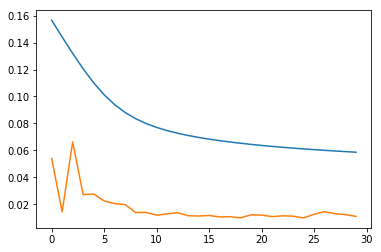

In [59]:
dfs = analysis.trial_dataframes
for d in dfs.values():
    print(type(d))
[d.mean_accuracy.plot() for d in dfs.values()]

In [41]:
for k in dfs:
    df = dfs[k]
    break

In [42]:
df.shape

(30, 19)

In [43]:
df

,mean_accuracy,mean_loss,trial_id,training_iteration,time_this_iter_s,done,timesteps_total,episodes_total,neg_mean_loss,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore
0,0.156613,1.156613,f5ab6c9e,0,0.158537,False,NaN,NaN,-1.156613,996947082ea0473cab4c7cd585fe9438,2019-12-11_00-08-23,1576019303,0.158537,13497,krzysztof-ThinkPad-X1-Carbon-3rd,192.168.0.78,0.158537,0,1
1,0.144161,1.144161,f5ab6c9e,1,0.144723,False,NaN,NaN,-1.144161,996947082ea0473cab4c7cd585fe9438,2019-12-11_00-08-23,1576019303,0.303260,13497,krzysztof-ThinkPad-X1-Carbon-3rd,192.168.0.78,0.303260,0,2
2,0.132025,1.132025,f5ab6c9e,2,0.169007,False,NaN,NaN,-1.132025,996947082ea0473cab4c7cd585fe9438,2019-12-11_00-08-23,1576019303,0.472267,13497,krzysztof-ThinkPad-X1-Carbon-3rd,192.168.0.78,0.472267,0,3
3,0.120559,1.120559,f5ab6c9e,3,0.139969,False,NaN,NaN,-1.120559,996947082ea0473cab4c7cd585fe9438,2019-12-11_00-08-23,1576019303,0.612236,13497,krzysztof-ThinkPad-X1-Carbon-3rd,192.168.0.78,0.612236,0,4
4,0.110188,1.110188,f5ab6c9e,4,0.150290,False,NaN,NaN,-1.110188,996947082ea0473cab4c7cd585fe9438,2019-12-11_00-08-23,1576019303,0.762525,13497,krzysztof-ThinkPad-X1-Carbon-3rd,192.168.0.78,0.762525,0,5
5,0.101269,1.101269,f5ab6c9e,5,0.179209,False,NaN,NaN,-1.101269,996947082ea0473cab4c7cd585fe9438,2019-12-11_00-08-24,1576019304,0.941734,13497,krzysztof-ThinkPad-X1-Carbon-3rd,192.168.0.78,0.941734,0,6
6,0.093948,1.093948,f5ab6c9e,6,0.247928,False,NaN,NaN,-1.093948,996947082ea0473cab4c7cd585fe9438,2019-12-11_00-08-24,1576019304,1.189662,13497,krzysztof-ThinkPad-X1-Carbon-3rd,192.168.0.78,1.189662,0,7
7,0.088124,1.088124,f5ab6c9e,7,0.171880,False,NaN,NaN,-1.088124,996947082ea0473cab4c7cd585fe9438,2019-12-11_00-08-24,1576019304,1.361542,13497,krzysztof-ThinkPad-X1-Carbon-3rd,192.168.0.78,1.361542,0,8
8,0.083548,1.083548,f5ab6c9e,8,0.144833,False,NaN,NaN,-1.083548,996947082ea0473cab4c7cd585fe9438,2019-12-11_00-08-24,1576019304,1.506375,13497,krzysztof-ThinkPad-X1-Carbon-3rd,192.168.0.78,1.506375,0,9
9,0.079937,1.079937,f5ab6c9e,9,0.145505,False,NaN,NaN,-1.079937,996947082ea0473cab4c7cd585fe9438,2019-12-11_00-08-24,1576019304,1.651880,13497,krzysztof-ThinkPad-X1-Carbon-3rd,192.168.0.78,1.651880,0,10


In [38]:
df = analysis.dataframe()

2019-12-11 00:12:50,948	WARNING experiment_analysis.py:119 -- Couldn't read config from 2 paths


In [39]:
df.shape

(2, 19)

In [40]:
df

,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mean_accuracy,mean_loss,neg_mean_loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id
0,2019-12-11_00-08-28,False,NaN,996947082ea0473cab4c7cd585fe9438,krzysztof-ThinkPad-X1-Carbon-3rd,30,0.058620,1.058620,-1.058620,192.168.0.78,13497,5.285542,0.171469,5.285542,1576019308,0,NaN,29,f5ab6c9e
1,2019-12-11_00-08-36,False,NaN,8306d4cbd8ea49cd80f3b27140bc1e69,krzysztof-ThinkPad-X1-Carbon-3rd,30,0.010954,1.010954,-1.010954,192.168.0.78,13541,6.017578,0.145703,6.017578,1576019316,0,NaN,29,f5b1b2de


In [34]:
print("Best config is", analysis.get_best_config(metric="mean_accuracy"))

Best config is {'lr': 1.2750763656960608e-09, 'momentum': 0.37545547582131755}


In [46]:
df.columns

Index(['config/lr', 'config/momentum', 'date', 'done', 'episodes_total',
       'experiment_id', 'hostname', 'iterations_since_restore', 'logdir',
       'mean_accuracy', 'mean_loss', 'neg_mean_loss', 'node_ip', 'pid',
       'time_since_restore', 'time_this_iter_s', 'time_total_s', 'timestamp',
       'timesteps_since_restore', 'timesteps_total', 'training_iteration',
       'trial_id'],
      dtype='object')

In [80]:
analysis.__dir__()

['_experiment_state',
 '_checkpoints',
 'trials',
 '_experiment_dir',
 '_configs',
 '_trial_dataframes',
 '__module__',
 '__doc__',
 '__init__',
 'stats',
 'runner_data',
 '_get_trial_paths',
 'dataframe',
 'get_best_config',
 'get_best_logdir',
 'fetch_trial_dataframes',
 'get_all_configs',
 '_retrieve_rows',
 'trial_dataframes',
 '__dict__',
 '__weakref__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [51]:
print(len(analysis.trials))
print(type(analysis.trials[0]))
analysis.trials

2
<class 'ray.tune.trial.Trial'>


[train_0_lr=0.00036282,momentum=0.62465, train_1_lr=0.17721,momentum=0.34218]

In [53]:
str(analysis.trials[0])

'train_0_lr=0.00036282,momentum=0.62465'